In [774]:
import numpy as np
import scipy
import random
import pandas as pd
import pickle
import seaborn.objects as so
import hashlib
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats   

from IPython.display import display, HTML

In [68]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [1146]:
"""
%%scalene --profile-all --cli

def tester(x):
    c = 0
    for i in range(x):
        for j in range(10000):
            c += 1

tester(100)
"""

                                      [1146]: % of time = 100.00% (50.321ms) out of 50.321ms.                                      
       ╷       ╷       ╷       ╷       ╷                                                                                           
       │Time   │–––––– │–––––– │–––––– │                                                                                           
  Line │Python │native │system │GPU    │[1146]                                                                                     
╺━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
     1 │       │       │       │       │%%scalene --profile-all --cli                                                              
     2 │       │       │       │       │                                                                                           
     3 │       │       │       │       │def tester(x):                      

# Functions

Containerclass for standard operations on metrics

In [877]:
class MetricManager:
    def __init__(self, metrics):
        self.metrics = metrics

        self.runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)

        self.metrics_dfs = {
            "verma": {},
            "hemmer": {}
        }

    def get_dataframe_specific_run(self, run, method, seed, fold, step):
        """
        Returns a DataFrame for a given method of one (run, seed, fold) combination
        Step specifies the evaluation step (val, test)
        """
        if method == "verma":
            return self.create_dataframe_verma(run, seed, fold, step)
        if method == "hemmer":
            return self.create_dataframe_hemmer(run, seed, fold, step)

    def create_dataframe_verma(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for verma for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        #Drops redundant columns
        df = pd.DataFrame(self.metrics[run]["verma"][seed][fold][step]).drop(["acc_experts", "cov_experts"], axis=0).T
        #Extract the number of images from coverage text
        df["coverage"] = df["coverage"].apply(lambda x: getCountOfCoverage(x))
        #df.rename(columns={'coverage':'n_images'}, inplace=True)
        return df

    def create_dataframe_hemmer(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for hemmer for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        df = pd.DataFrame(self.metrics[run]["hemmer"][seed][fold][step]).T
        #Get the absolute number of images from the same combination from verma
        n_images = getCountOfCoverage(self.metrics[run]["verma"][seed][fold][step][0]["coverage"])
        #Extracts the experts ids
        experts = [column[7:] for column in df.columns if "Expert" in column]
        #Converts the percentage of coverage to absolute number
        df["Classifier Coverage"] = n_images * df["Classifier Coverage"]
        #Create metrics for every expert from list elements
        for expert in experts:
            df[f"{expert} Accuracy"] = [row["expert_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Subset Accuracy"] = [row["expert_task_subset_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Coverage"] = [n_images * row["expert_coverage"] for row in df[f"Expert_{expert}"]]
            df = df.drop([f"Expert_{expert}"], axis=1)
        return df

    def create_l2d_dataframe(self, method, step):
        """
        Creates a multiindex dataframe which contains all metrics for a L2D method and given step

        Result is a multiindex df (run, seed, fold)
        """
        dict_run = {}
        #Iterate over all runs
        for run in range(len(self.metrics)):
            dict_seed = {}
            #Iterate over all seeds
            for seed, val1 in self.metrics[run][method].items():
                dict_fold = {}
                #Iterate over every fold
                for fold, element in self.metrics[run][method][seed].items():
                    #Add metric for this (run, seed, fold) combination to the fold_dict
                    dict_fold[f"Fold_{fold}"] = self.get_dataframe_specific_run(run, method, seed, fold, step)
                #Create DataFrame for all folds in this (run, seed) combination
                df_seed = pd.concat(dict_fold)
                dict_seed[f"Seed_{seed}"] = df_seed
            #Create DataFrame for all seeds in this run
            df_run = pd.concat(dict_seed)
            dict_run[f"Run_{run}"] = df_run
        #Create DataFrame for all runs
        df_test = pd.concat(dict_run)
        return df_test

    def get_l2d_dataframe(self, method, step):
        """
        Returns the needed df

        Stores created dfs to speed up the process
        """
        if step not in self.metrics_dfs[method]:
            self.metrics_dfs[method][step] = self.create_l2d_dataframe(method, step)
        return self.metrics_dfs[method][step]

    def create_metric_dataframe_old(self, df, metric_name, method):
        """
        Creates the df for a L2D method and a specified aggregation method

        Current implemented are max and var for the aggregation of a (run, seed, fold) combination
        """
        dff = df[[metric_name]]
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()
        index_seeds = index.get_level_values(1).drop_duplicates()
        index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        for run in index_runs:
            run_list = []
            for seed in index_seeds:
                for fold in index_folds:
                    if method == "max":
                        run_list.append(dff.loc[(run, seed, fold)].max()[0])
                    if method == "var":
                        run_list.append(dff.loc[(run, seed, fold)].var()[0])
            values[run] = run_list
        return pd.DataFrame(values)

    def create_metric_dataframe(self, df, metric_name, method):
        """
        Creates the df for a L2D method and a specified aggregation method

        Current implemented are max and var for the aggregation of a (run, seed, fold) combination
        """
        dff = df[[metric_name]]
        indices = self.get_best_model_indices(method)
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()
        index_seeds = index.get_level_values(1).drop_duplicates()
        index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        run_count = 0
        for run in index_runs:
            run_list = []
            count = 0
            for seed in index_seeds:
                for fold in index_folds:
                    run_list.append(dff.loc[(run, seed, fold, indices.iloc[count, run_count])][0])
                    count += 1
                values[run] = run_list
            run_count += 1
        return pd.DataFrame(values)

    def get_best_model_indices(self, method):
        """
        Creates the df for a L2D method and a specified aggregation method

        Current implemented are max and var for the aggregation of a (run, seed, fold) combination
        """
        df = self.get_l2d_dataframe(method, "val") #Get metrics for every run, seed, fold
        dff = df[["system_accuracy"]]
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()
        index_seeds = index.get_level_values(1).drop_duplicates()
        index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        for run in index_runs:
            run_list = []
            for seed in index_seeds:
                for fold in index_folds:
                    run_list.append(pd.to_numeric(dff.loc[(run, seed, fold), "system_accuracy"]).idxmax())
            values[run] = run_list
        return pd.DataFrame(values)

    def get_metric_dataframe(self, method, step, metric_name):
        """
        Returns a dataframe for one metric

        Columns are runs, rows are the max/var of the L2D systems metric for every fold
        """
        df = self.get_l2d_dataframe(method, step) #Get metrics for every run, seed, fold
        return self.create_metric_dataframe(df, metric_name, method)

    def get_metrics_dataframe_cut(self, method, step, metric_name, unwanted_tuple=None):
        """
        Cuts the name and add the posibility to remove unwanted parameter-value pairs
        """
        df = cut_column_name(self.get_metric_dataframe(method, step, metric_name))
        columns = df.columns
        if unwanted_tuple is not None: # Get only indieces of runs without unwanted parameter-value pairs
            columns = [str(el) for el in list(remove_unwanted_runs(df_runs, unwanted_tuple).index)]
        return df.loc[:,columns] #Return metric for every run with applied method to aggregate seeds and folds
        

    def print_metrics(self, df):
        """
        Prints the columns of a drataframe to get all available metrics
        """
        print(df.columns)

def getCountOfCoverage(text):
    """
    Returns the number of images from the verma-metric coverage text
    """
    marker = None
    for j in range(len(text)):
        if text[-j] == "f":
            marker = j -1
    return int(text[-marker:])

def cut_column_name(df):
    columns = [column[4:] for column in df.columns]
    df.columns = columns
    return df

### t-Test Functions

In [898]:
def check_all_ttest(df, p=0.05, equal_var=False, plot=False):
    """
    Checks all columns of the dataframe of statistical significance
    """
    matrix = {}
    for i in df.columns:
        row = {}
        for j in df.columns:
            if i == j:
                row[j] = 1
            else:
                res = get_ttest(df.loc[:,[i]], df.loc[:,[j]], equal_var=equal_var)
                row[j] = res.pvalue[0]
        matrix[i] = row

    if plot:
        df = pd.DataFrame(matrix)
        plot_ttests(df)
    return matrix

def get_ttest(value1, value2, equal_var=True):
    res = ttest_ind(value1, value2, equal_var=equal_var, nan_policy="omit")
    #print(res)
    return res

def plot_ttests(df):
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(25, 11))
    sns.heatmap(df, annot=True, linewidths=.5, ax=ax)

## Functions to group runs

In [1017]:
def get_rungroup_name(df_runs, runs_g, var_columns, reverse=False):
    """
    Create names for every run where the runs differentiate in parameters

    Input:
        df_runs: DataFrame with every run and its parameters
        runs_g: Group of runs in structure [[0, 1, 2], [3, 4]]
        var_columns: Names of columns which can vary in a aggregated run
        reverse: If all columns could vary except of the given ones

    Return:
        run_names: Names for every run
        keys: Columnnames in which the runs are different
    """
    const_columns = [column for column in df_runs.columns if column not in var_columns]
    if reverse:
        const_columns = var_columns

    group_dict = []
    for run_group in runs_g:
        group_dict.append(dict(df_runs.loc[run_group[0], const_columns]))

    keys = []
    for i in range(len(group_dict) - 1):
        temp_keys = [k for k in group_dict[i] if group_dict[i][k] != group_dict[i + 1][k]]
        for key in temp_keys:
            if key not in keys:
                keys.append(key)
    keys.reverse()

    run_names = []
    for run_group in runs_g:
        run_names.append(create_run_name_from_columns(df_runs.loc[run_group[0]], keys))

    return run_names, keys

def create_run_name_from_columns(run, columns):
    """
    Concats names of columns with value for one run

    Input:
        run: DataFrame which contains one run with its parameters
        columns: The columns to build the name

    Return:
        Concated string from column-value pairs
    """
    name = ""
    #columns.reverse()
    for column in columns:
        name = name + f"{column}_{run.loc[column]}_"
    return name[:-1]

def remove_unwanted_runs(df, unwanted_tuples):
    """
    Removes runs which contains unwanted column-value combinations

    Input:
        df - DataFrame which contains all runs
        unwanted_tuples - List of (column, value) pairs which should be removed
    """
    if isinstance(unwanted_tuples, tuple): #Make sure a single tuple doesn't break the code
        unwanted_tuples = [unwanted_tuples]
    dff = df
    for pair in unwanted_tuples:
        if (pair[0] in dff.columns): #Check if the column exists in the DataFrame
            dff = dff[dff[pair[0]] != pair[1]]
    return dff

def get_runs_grouped(df, var_columns, reverse=False):
    """
    Groups the runs by their parameters
    All parameters except the passed ones are equal

    Returns a list whichs elements are lists of equal runs like [[0, 1, 2], [3, 4, 5]]
    """
    #Gets the columns which defines a aggregated run (stay constant for on aggregation)
    const_columns = [column for column in df.columns if column not in var_columns]
    #If all columns should be variable except the given ones
    if reverse:
        const_columns = var_columns

    pairs = []
    referenc_row = None
    index_list = list(df.index)
    #For every run in the dataframe
    for index in df.index:
        #If the run already is aggregated into one group
        if index in [el for sublist in pairs for el in sublist]:
            continue
        #Remove index to prevent adding it into the group to himself
        index_list.remove(index)
        #Get the reference row with the conctant columns
        referenc_row = df.loc[index, const_columns].to_dict()
        pair = [index]
        #Look at all other runs
        for index_j in index_list:
            current_row = df.loc[index_j, const_columns].to_dict()
            #If the current row equals the reference  row in the constant columns
            if referenc_row == current_row:
                pair.append(index_j)
        #Removed aggregated rows to prevent aggregation into different groups
        for el in pair:
            if el in index_list:
                index_list.remove(el)
        pairs.append(pair)
    return pairs

def get_runs_grouped_metric(df_runs, df_metrics, var_columns, reverse=False, unwanted_tuples=None):
    """
    Returns a DataFrame where the runs are aggregated and metrics for are combined for a aggregation

    A Aggregated run contains all metrics for every run it contains
    
    Parameter:
        var_columns are the coulmns which aren't fix, all other are
        Reverse makes all columns variable except var_columns

    Return:
        df - The DataFrame which contains aggregated runs with metrics
        df_runs.loc[first_indices, keys] - List of the aggregated runs from df_runs to show the parameters of the aggregated runs
    """

    #Remove unwanted runs
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    #Get groups of runs
    g_runs = get_runs_grouped(df_runs, var_columns, reverse)
    df = None
    first_indices = []
    for run_group in g_runs:
        #Append first run of group to show the parameters of a group
        first_indices.append(run_group[0])
        values = []
        #For every run in a group
        for run in run_group:
            #Aggregate the values of every run in this group
            values = values + df_metrics[str(run)].tolist()
        #Create Dataframe with aggregated values
        dff = pd.DataFrame(values, columns=[str(run_group)])
        #If first element of the group create Dataframe
        if df is None:
            df = dff
        else: #Concat for every other run in the group
            df = pd.concat([df, dff], axis=1)

    #keys are the columns of runs where the values are different in the aggregated runs
    #Prevents from printing column-values which are constant over all run groups
    df.columns, keys = get_rungroup_name(df_runs, g_runs, var_columns, reverse)

    df.columns = df_runs.loc[first_indices, keys].index
    
    return df, df_runs.loc[first_indices, keys]

def get_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None):
    """
    Creates a DataFrame in long formate (for seaborn) which groups runs over equal columns and changing var_columns

    Parameter:
        df_runs: DataFrame containing all runs
        df_metrics: DataFrame containing values for one metric over every run and every fold (Columns are runs, rows are the max/var of the L2D systems metric for every fold)
        var_columns: Columns which can vary in a aggregated run
        unwanted_tuples: parameter-value pairs of runs which should be removed
    """
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    
    g_runs = get_runs_grouped(df_runs, var_columns, False)

    df = None
    first_indices = []
    dfs = []
    for run_group in g_runs:
        first_indices.append(run_group[0])
        values = {}
        run_dfs = []
        for run in run_group:
            temp_dict = {
                "value": df_metrics[str(run)],
            }
            for column in var_columns:
                temp_dict[column] = [df_runs.loc[run, column] for i in range(len(temp_dict["value"]))]
            df = pd.DataFrame(temp_dict)
            #print(df)
            run_dfs.append(df)
        dff = pd.concat(run_dfs)
        dff["group"] = [run_group[0] for i in range(len(dff))]
        dfs.append(dff)

    _, keys = get_rungroup_name(df_runs, g_runs, var_columns, False)
    
    return pd.concat(dfs), df_runs.loc[first_indices, keys]

def plot_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None, y_text="value"):
    df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, unwanted_tuples)

    f, ax = plt.subplots(figsize=(25, 11))

    display(HTML(runs_df.to_html()))

    g = sns.boxplot(df, y="value", x="group", hue=df[var_columns].apply(tuple, axis=1))

    ax.set(xlabel='group', ylabel=y_text)

    series = pd.Series(df[var_columns].apply(tuple, axis=1))
    for i in range(len(var_columns)):
        name = var_columns[i]
        for j, el in enumerate(series):
            el = list(series.iloc[j])
            el[i] = f"{name}: {el[i]}"
            series.iloc[j] = tuple(el)

    plt.legend(loc='upper right')
    for t, l in zip(g.legend_.texts, list(series.unique())):
        t.set_text(l)

    plt.show(g)

    return df, runs_df

def get_uniq_values(df, column):
    if column in df.columns:
        return set(df[column].values)

def group_ttest(df, plot=False):

    group_test = []
    df = runs_cost_to_string(df)
    for group in get_uniq_values(df, "group"):
        group_df = df[df["group"] == group]

        columns = list(group_df.columns)
        columns.remove("value")
        columns.remove("group")

        dff = group_df.pivot(columns=columns, values='value')

        group_test.append(pd.DataFrame(check_all_ttest(dff)))

    return group_test

def runs_cost_to_string(df):
    df = df.copy()
    if "cost" in df.columns:
        df["cost"] = df["cost"].apply(lambda x: cost_to_string(x))
    #df_runs.loc[:, "cost"] = [cost_to_string(cost) for cost in df_runs["cost"]]
    return df

def cost_to_string(cost):
    #return "(" + ''.join(cost) + ")"
    return str(cost)

## Playground

# Analysis

Load current metrics

In [1065]:
import glob

with open("Metrics_Folder/Metrics_97.pickle", 'rb') as handle:
    metrics = pickle.load(handle)

metricManager = MetricManager(metrics)

In [1049]:
#for run_id in range(len(metrics)):
#    metrics[run_id]["epochs_pretrain"] = 0

In [698]:
#import lzma
#
#with lzma.open("Current_Metric.xz", "wb") as handle:
#    pickle.dump(metrics, handle)

In [1053]:
#with open(f'Metrics_Folder/Metrics_{77}.pickle', 'wb') as handle:
#    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

All experiment runs with every parameter combination

In [1066]:
df_runs = metricManager.runs
df_runs

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0   [4323195249, 4295232296]          0                 4       8       32   
1   [4323195249, 4295232296]          8                 4       2       16   
2   [4323195249, 4295232296]          8                 4       2       16   
3   [4323195249, 4295232296]          8                 4       2       16   
4   [4323195249, 4295232296]          8                 4       2       16   
..                       ...        ...               ...     ...      ...   
92  [4323195249, 4295232296]          8                 4       2       16   
93  [4323195249, 4295232296]          8                 4       2       16   
94  [4323195249, 4295232296]          8                 4       2       16   
95  [4323195249, 4295232296]          8                 4       2       16   
96  [4323195249, 4295232296]          8                 4       2       16   

      cost  overlap  setting                mod expert_predict  sample_equal  \
0   (0, 0)        5  PERFECT            perfect         target         False   
1   (0, 0)        0       AL         confidence          right         False   
2   (0, 0)        0       AL         confidence          right          True   
3   (0, 0)        0       AL         confidence         target         False   
4   (0, 0)        0       AL         confidence         target          True   
..     ...      ...      ...                ...            ...           ...   
92  (0, 0)        0   SSL_AL         confidence         target          True   
93  (0, 0)        0   SSL_AL       disagreement         target         False   
94  (0, 0)        0   SSL_AL       disagreement         target          True   
95  (0, 0)        0   SSL_AL  disagreement_diff         target         False   
96  (0, 0)        0   SSL_AL  disagreement_diff         target          True   

    epochs_pretrain  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
92               25  
93               25  
94               25  
95               25  
96               25  

[97 rows x 12 columns]

All columns

Verma:

In [791]:
metricManager.get_l2d_dataframe("verma", "val").columns

Index(['n_images', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')

Hemmer:

In [792]:
metricManager.get_l2d_dataframe("hemmer", "val").columns

Index(['system_accuracy', 'train_system_loss', 'Classifier Accuracy',
       'Classifier Task Subset Accuracy', 'Classifier Coverage',
       '4323195249 Accuracy', '4323195249 Subset Accuracy',
       '4323195249 Coverage', '4295232296 Accuracy',
       '4295232296 Subset Accuracy', '4295232296 Coverage'],
      dtype='object')

#### Plot single runs

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0   [4323195249, 4295232296]          0                 4       8       32   
1   [4323195249, 4295232296]          8                 4       2       16   
2   [4323195249, 4295232296]          8                 4       2       16   
3   [4323195249, 4295232296]          8                 4       2       16   
4   [4323195249, 4295232296]          8                 4       2       16   
..                       ...        ...               ...     ...      ...   
92  [4323195249, 4295232296]          8                 4       2       16   
93  [4323195249, 4295232296]          8                 4       2       16   
94  [4323195249, 4295232296]          8                 4       2       16   
95  [4323195249, 4295232296]          8                 4       2       16   
96  [4323195249, 4295232296]          8                 4       2       16   

      cost  overlap  setting                mod expert_predict  sample_equal  \
0   (0, 0)        5  PERFECT            perfect         target         False   
1   (0, 0)        0       AL         confidence          right         False   
2   (0, 0)        0       AL         confidence          right          True   
3   (0, 0)        0       AL         confidence         target         False   
4   (0, 0)        0       AL         confidence         target          True   
..     ...      ...      ...                ...            ...           ...   
92  (0, 0)        0   SSL_AL         confidence         target          True   
93  (0, 0)        0   SSL_AL       disagreement         target         False   
94  (0, 0)        0   SSL_AL       disagreement         target          True   
95  (0, 0)        0   SSL_AL  disagreement_diff         target         False   
96  (0, 0)        0   SSL_AL  disagreement_diff         target          True   

    epochs_pretrain  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
92               25  
93               25  
94               25  
95               25  
96               25  

[97 rows x 12 columns]

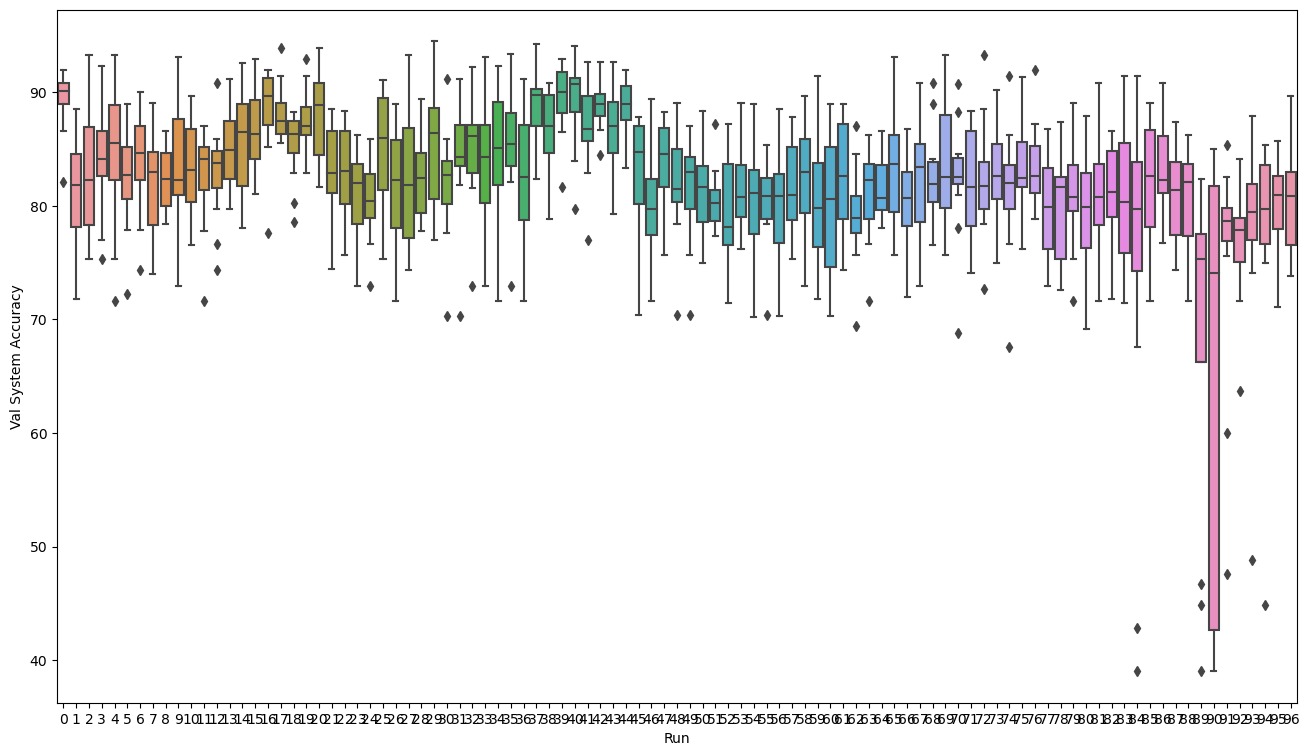

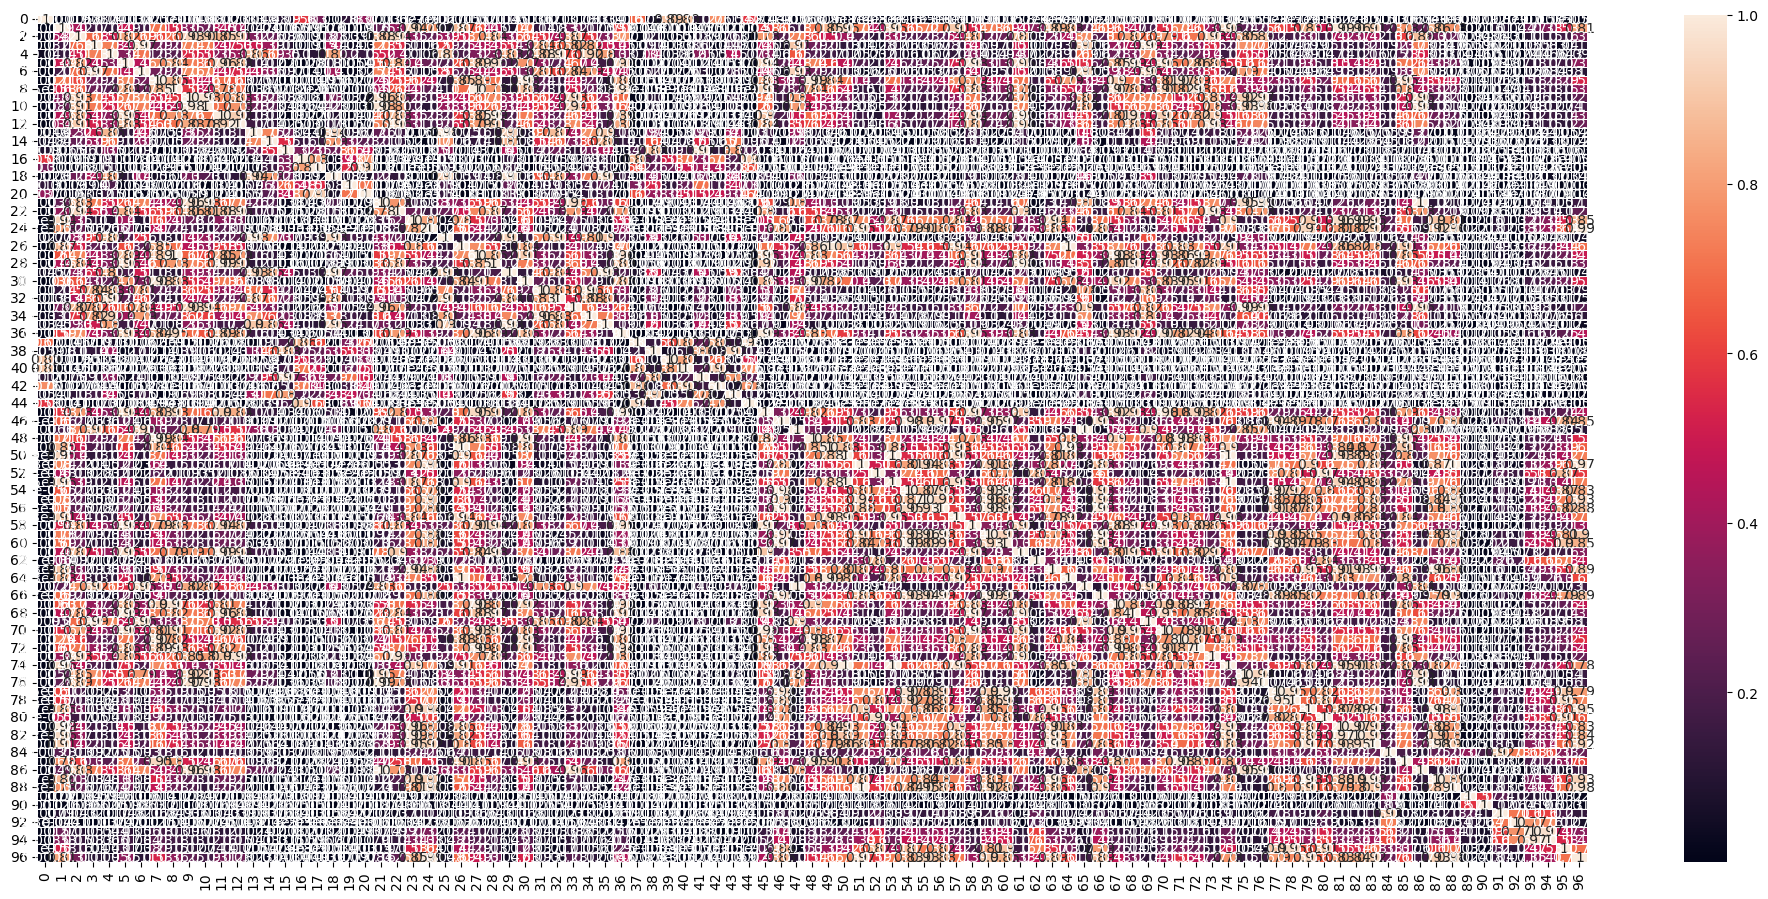

In [1067]:
#exclude = [("expert_predict", "target")]
exclude = None

df_accuracy = metricManager.get_metrics_dataframe_cut("verma", "test", "system_accuracy", exclude)
f, ax = plt.subplots(figsize=(16, 9))
ax.set(xlabel='Run', ylabel='Val System Accuracy')
sns.boxplot(df_accuracy)

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

df_runs.loc[[int(el) for el in df_accuracy.columns]]

In [959]:
metrics[0]["verma"][1][0]["val"]

{0: {'coverage': '36 out of168',
  'system_accuracy': 86.30952380952381,
  'expert_accuracy': 89.3938039487819,
  'classifier_accuracy': 74.99979166724536,
  'alone_classifier': 59.523809523809526,
  'validation_loss': 3.8006774187088013,
  'n_experts': 2,
  'expert_0': 94.11737024302869,
  'expert_1': 84.37473632894897,
  'expert_0_coverage': 68,
  'expert_1_coverage': 64,
  'cov_classifier': 36,
  'acc_experts': [94.11737024302869, 84.37473632894897],
  'cov_experts': [68, 64]},
 1: {'coverage': '5 out of168',
  'system_accuracy': 89.88095238095238,
  'expert_accuracy': 90.18393842461542,
  'classifier_accuracy': 79.99840003199937,
  'alone_classifier': 73.21428571428571,
  'validation_loss': 2.978061318397522,
  'n_experts': 2,
  'expert_0': 92.03523533586666,
  'expert_1': 85.999656001376,
  'expert_0_coverage': 113,
  'expert_1_coverage': 50,
  'cov_classifier': 5,
  'acc_experts': [92.03523533586666, 85.999656001376],
  'cov_experts': [113, 50]},
 2: {'coverage': '11 out of168',


## Group runs

In [945]:
metricManager.get_l2d_dataframe("verma", "val").columns

Index(['n_images', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')

In [1059]:
df_runs.head(2)

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0  [4323195249, 4295232296]          0                 4       8       32   
1  [4323195249, 4295232296]          8                 4       2       16   

     cost  overlap  setting         mod expert_predict  sample_equal  \
0  (0, 0)        5  PERFECT     perfect         target         False   
1  (0, 0)        0       AL  confidence          right         False   

   epochs_pretrain  
0                0  
1                0

epochs_pretrain                mod  setting  labeled  rounds  init_size
0                 0            perfect  PERFECT       32       8          0
3                 0         confidence       AL       16       2          8
7                 0       disagreement       AL       16       2          8
11                0  disagreement_diff       AL       16       2          8
13                0                ssl      SSL       16       2          8
15                0         confidence   SSL_AL       16       2          8
17                0       disagreement   SSL_AL       16       2          8
19                0  disagreement_diff   SSL_AL       16       2          8
23                0             normal   NORMAL       16       2          8
67                0         confidence       AL       24       4          8
71                0       disagreement       AL       24       4          8
75                0  disagreement_diff       AL       24       4          8
79               25         confidence       AL       16       2          8
83               25       disagreement       AL       16       2          8
87               25  disagreement_diff       AL       16       2          8
89               25                ssl      SSL       16       2          8
91               25         confidence   SSL_AL       16       2          8
93               25       disagreement   SSL_AL       16       2          8

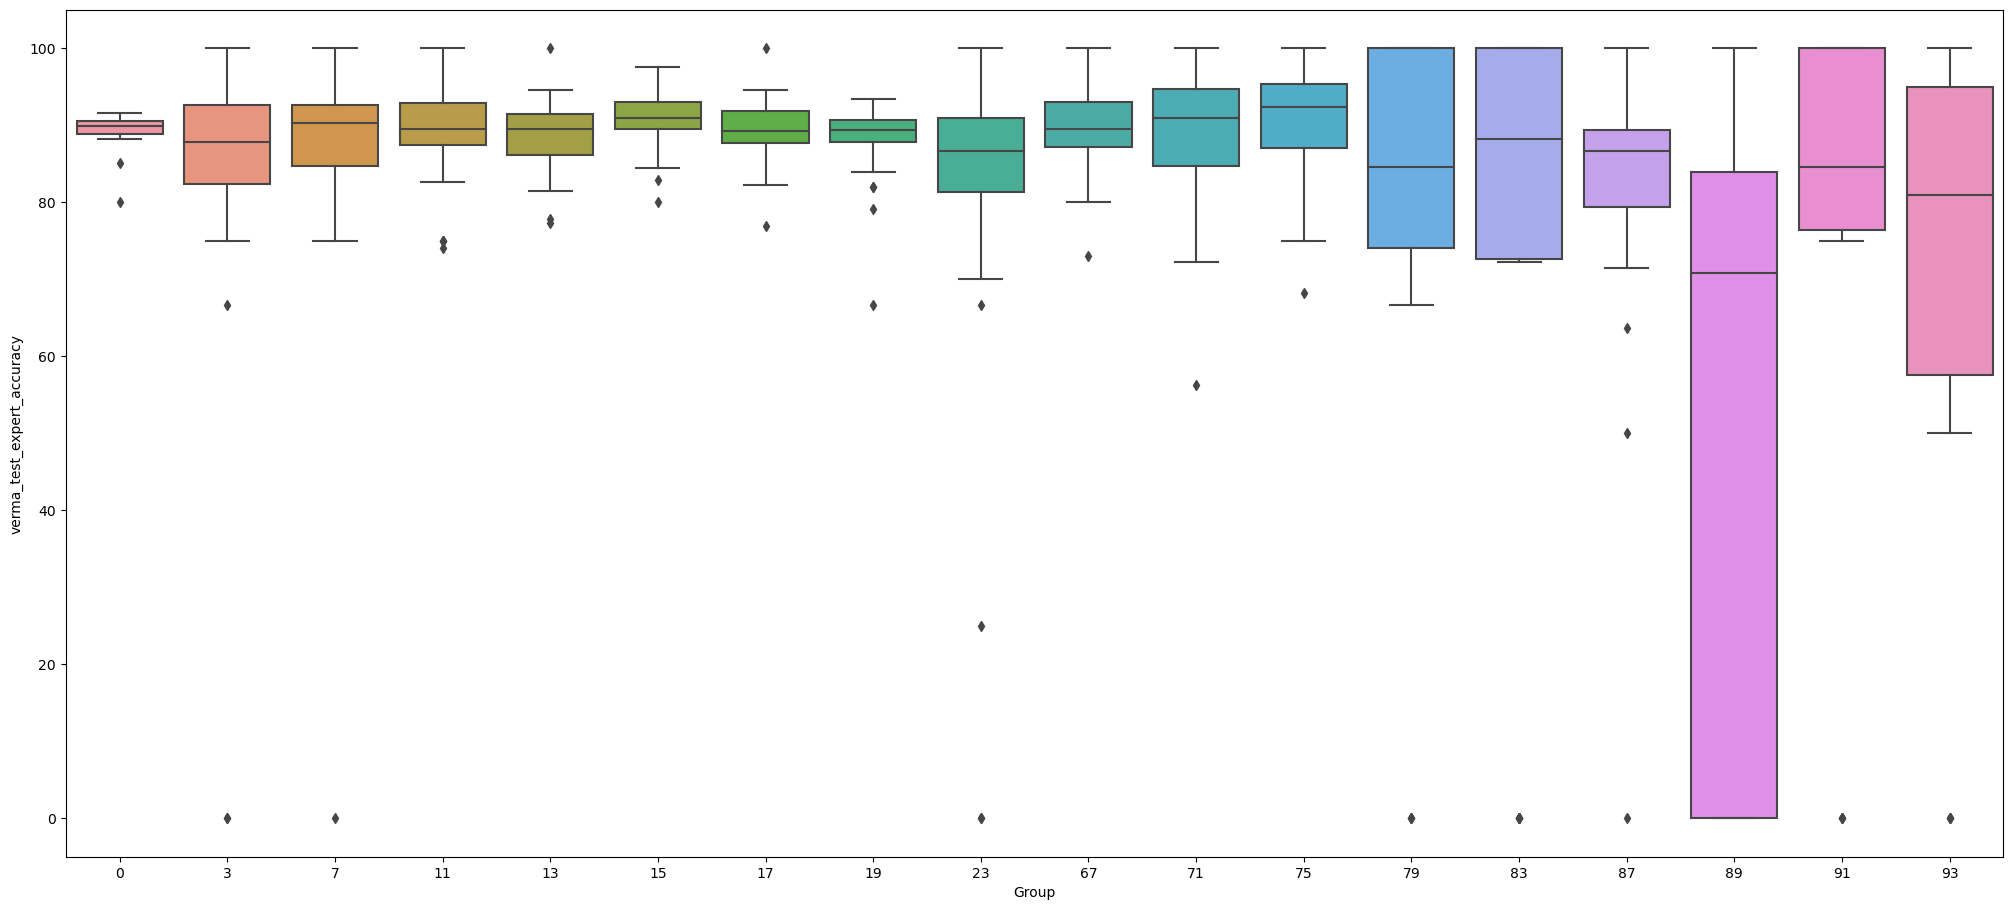

In [1069]:
var_columns = ["sample_equal", "overlap"]
cut_out = [("expert_predict", "right")]

method = "verma"
metric_name = "expert_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df, selected_runs = get_runs_grouped_metric(df_runs.iloc[:-2], df_test, var_columns, False, cut_out)
f, ax = plt.subplots(figsize=(25, 11))
ax.set(xlabel='Group', ylabel=f"{method}_{step}_{metric_name}")
sns.boxplot(df)

#check_all_ttest(df, plot=True)

selected_runs.head(30)

### With hue

In [909]:
var_columns = ["sample_equal", "overlap", "cost", "labeled"]

cut_out = [("expert_predict", "right")]

df_test = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy"))
df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, cut_out)
group_test = group_ttest(df)

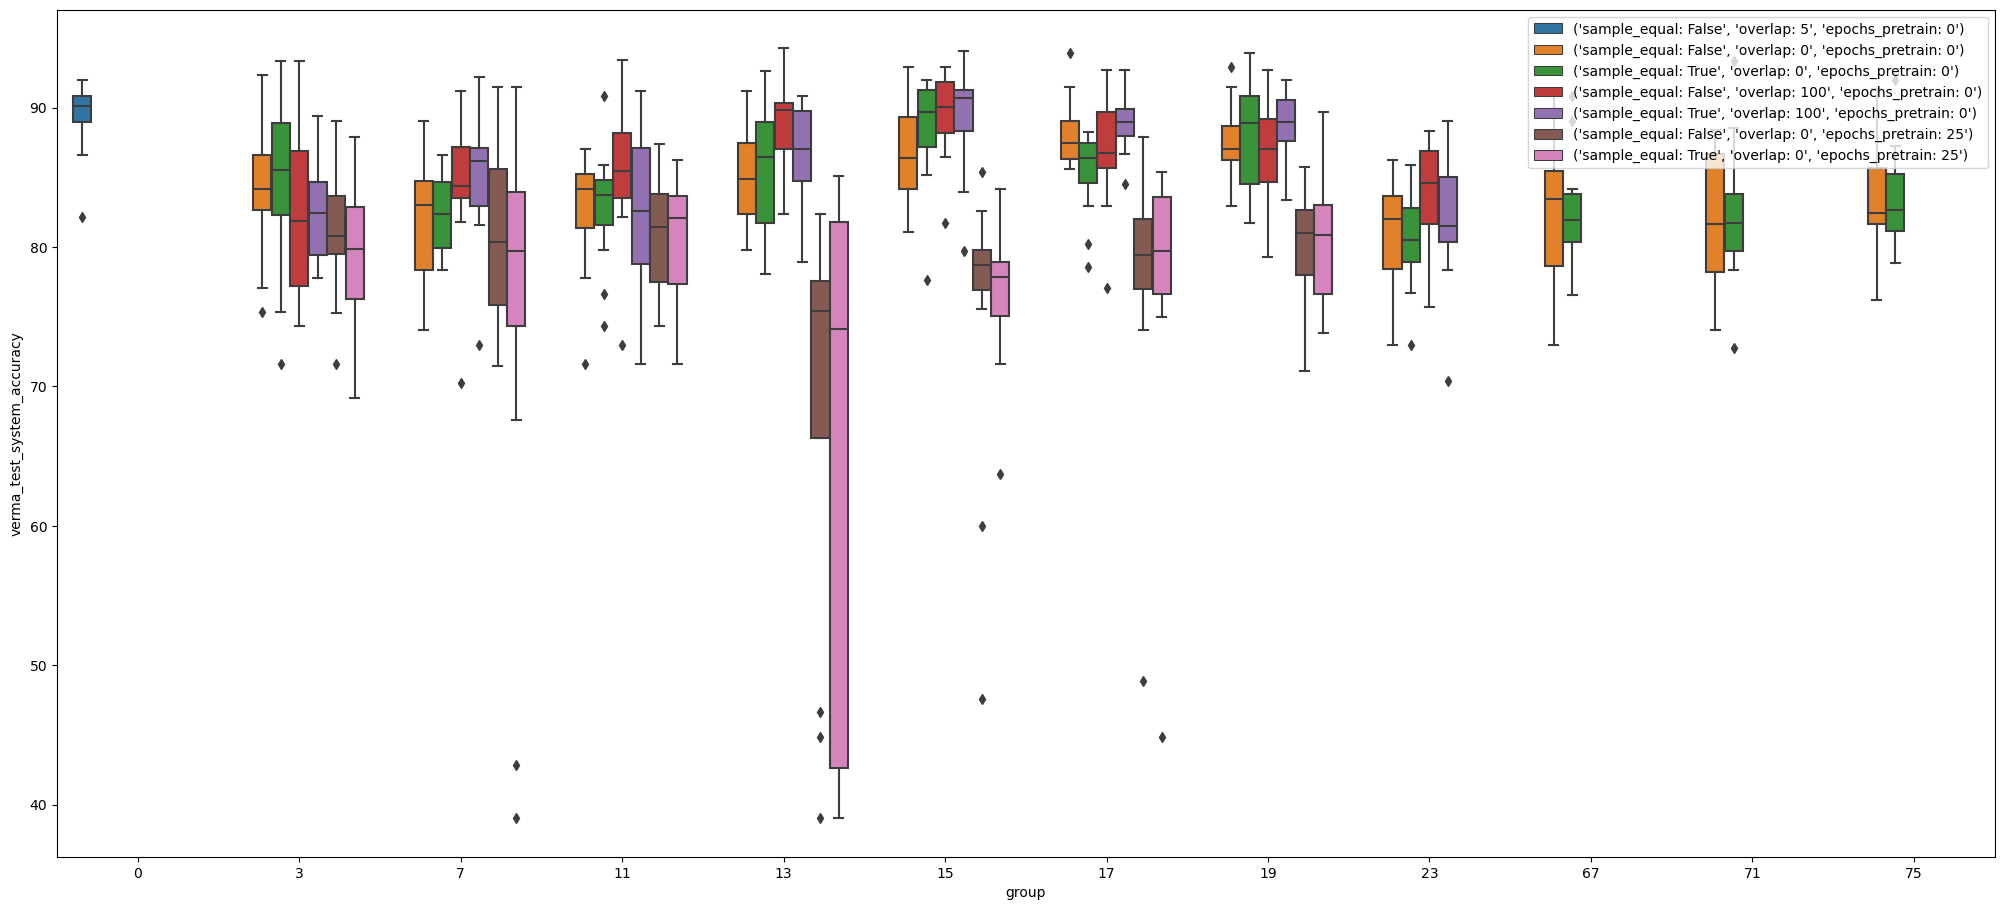

In [1070]:
var_columns = ["sample_equal", "overlap", "epochs_pretrain"]
cut_out = [("expert_predict", "right")]

method = "verma"
metric_name = "system_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df, runs_df = plot_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, cut_out, y_text=f"{method}_{step}_{metric_name}")
group_test = group_ttest(df)

In [1004]:
series = pd.Series(df[var_columns].apply(tuple, axis=1))
for i in range(len(var_columns)):
    name = var_columns[i]
    for j, el in enumerate(series):
        el = list(series.iloc[j])
        el[i] = f"{name}: {el[i]}"
        series.iloc[j] = tuple(el)
list(series.unique())
    

[('sample_equal: False', 'overlap: 5'),
 ('sample_equal: False', 'overlap: 0'),
 ('sample_equal: True', 'overlap: 0'),
 ('sample_equal: False', 'overlap: 100'),
 ('sample_equal: True', 'overlap: 100')]

### Test area

<Axes: >

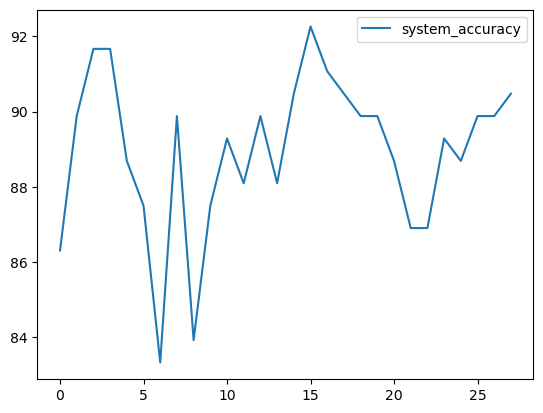

In [726]:
df = metricManager.get_l2d_dataframe("verma", "val")[["system_accuracy"]]
run = 0
seed = 0
df = df.iloc[0:28].reset_index(drop=True)
sns.lineplot(df)

## Experts

In [940]:
metrics[0]

[0,
 3,
 4,
 7,
 8,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 23,
 24,
 27,
 28,
 31,
 32,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 47,
 48,
 67,
 68,
 71]

In [ ]:
def create_start_end_df(metrics, step, metric_name, unwanted_tuples):

    assert step in ["val", "test"]
    
    runs_df = remove_unwanted_runs(df_runs, unwanted_tuples)
    indices = list(runs_df.index)

    
    for run_id in indices:
        
        for seed, seed_metrics in metrics[run_id]["expert metrics"].items():
            for fold, fold_metrics in seed_metrics.items():
                for expert, expert_metrics in fold_metrics.items():
                    
                    if expert not in met:
                        met[expert] = {}
                    if "Start" in expert_metrics[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
                    
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    

In [942]:
run = 1
fold = 0
seed = 1
expert = 4323195249

metrics[run]["expert metrics"][seed][fold][expert]["Val"]

{'Start': {'tn': 14,
  'fp': 0,
  'fn': 132,
  'tp': 22,
  'accurancy': 21.428571428571427,
  'f1': 0.25,
  'accurancy_balanced': 0.5714285714285714},
 'End': {'tn': 9,
  'fp': 5,
  'fn': 94,
  'tp': 60,
  'accurancy': 41.07142857142857,
  'f1': 0.547945205479452,
  'accurancy_balanced': 0.5162337662337663}}

In [923]:
import matplotlib.pyplot as plt

def get_expert_values(step, metric_name):

    mett = []
    for element in metrics:
        met = {}
        for seed, value1 in element["expert metrics"].items():
            for fold, value2 in value1.items():
                for expert, value3 in value2.items():
                    if expert not in met:
                        met[expert] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    if "Start" in value3[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
        mett.append(met)
    return mett

def get_single_values(met, run, expert_id, step):
    values = []
    for key, value in met[run][expert_id].items():
        values.append(value[step])
    return values

def plot_expert_values(met):
    df1 = pd.DataFrame(met[4323195249])
    df2 = pd.DataFrame(met[4295232296])

    fd1 = df1.T.reset_index()
    fd1["expert"] = 4323195249
    fd2 = df2.T.reset_index()
    fd2["expert"] = 4295232296
    df3 = pd.concat([fd1, fd2])
    df3 = df3.melt(id_vars=["index", "expert"])

    plt.figure()
    sns.boxplot(df3, x="expert", y="value",
            hue="variable",)

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0   [4323195249, 4295232296]          0                 4       8       32   
1   [4323195249, 4295232296]          8                 4       2       16   
2   [4323195249, 4295232296]          8                 4       2       16   
3   [4323195249, 4295232296]          8                 4       2       16   
4   [4323195249, 4295232296]          8                 4       2       16   
..                       ...        ...               ...     ...      ...   
67  [4323195249, 4295232296]          8                 4       4       24   
68  [4323195249, 4295232296]          8                 4       4       24   
69  [4323195249, 4295232296]          8                 4       4       24   
70  [4323195249, 4295232296]          8                 4       4       24   
71  [4323195249, 4295232296]          8                 4       4       24   

      cost  overlap  setting           mod expert_predict  sample_equal  
0   (0, 0)        5  PERFECT       perfect         target         False  
1   (0, 0)        0       AL    confidence          right         False  
2   (0, 0)        0       AL    confidence          right          True  
3   (0, 0)        0       AL    confidence         target         False  
4   (0, 0)        0       AL    confidence         target          True  
..     ...      ...      ...           ...            ...           ...  
67  (0, 0)        0       AL    confidence         target         False  
68  (0, 0)        0       AL    confidence         target          True  
69  (0, 0)        0       AL  disagreement          right         False  
70  (0, 0)        0       AL  disagreement          right          True  
71  (0, 0)        0       AL  disagreement         target         False  

[72 rows x 11 columns]

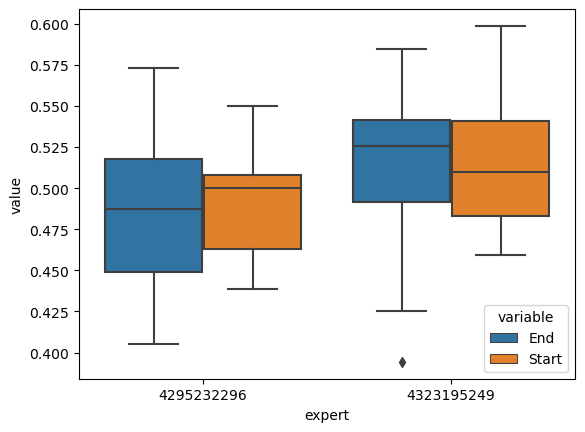

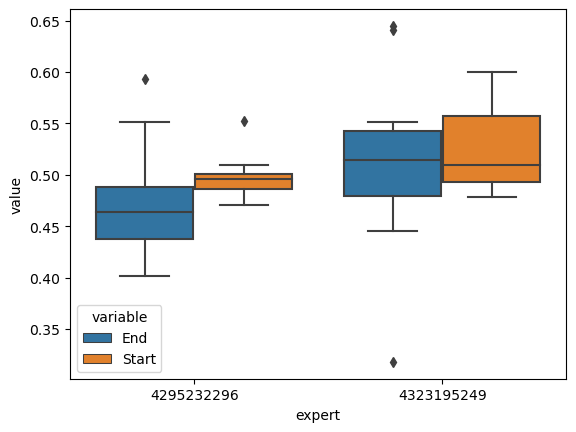

In [924]:
met = get_expert_values("Val", "accurancy_balanced")

plot_expert_values(met[2])
plot_expert_values(met[1])
df_runs

In [925]:
met = get_expert_values("Val", "accurancy_balanced")

In [931]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

def get_expert_df(metrics, expert_id, start=False):
    if start:
        df1 = pd.DataFrame([row["Start"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='start')
    df2 = pd.DataFrame([row["End"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='end')

    if start:
        df_final = df1
        df_final["end"] = df2["end"]
    else:
        df_final = df2
    df_final = df_final.melt(id_vars=["index", "seed_fold"], var_name="step")

    return df_final

def plot_expert_runs_al(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id, start=True)
    plt.figure()
    f, ax = plt.subplots(figsize=(25, 11))
    sns.boxplot(df, x="index", y="value", hue="step", ax=ax)

def plot_expert_runs_end(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id)
    plt.figure()
    f, ax = plt.subplots(figsize=(25, 11))
    sns.boxplot(df, x="index", y="value", ax=ax)

In [936]:
display(HTML(df_runs.to_html()))

<Figure size 640x480 with 0 Axes>

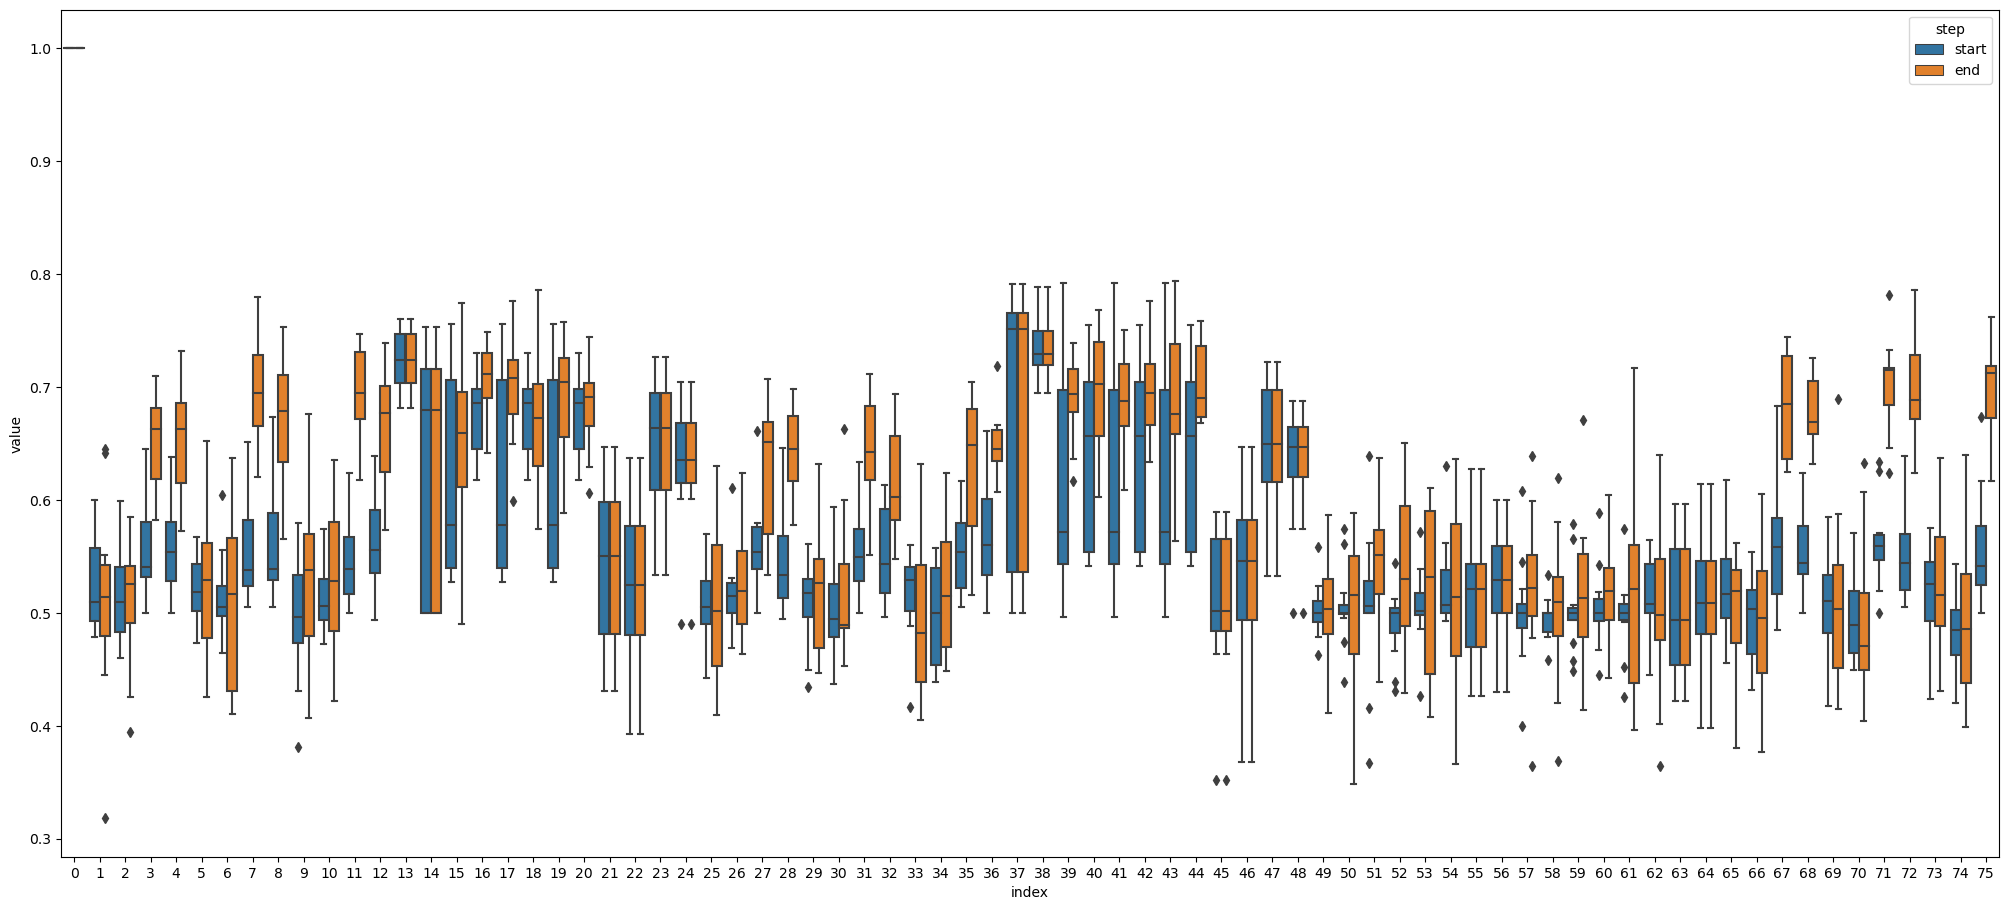

In [1027]:
plot_expert_runs_al(metrics, 4323195249, "Val", "accurancy_balanced")

<Figure size 640x480 with 0 Axes>

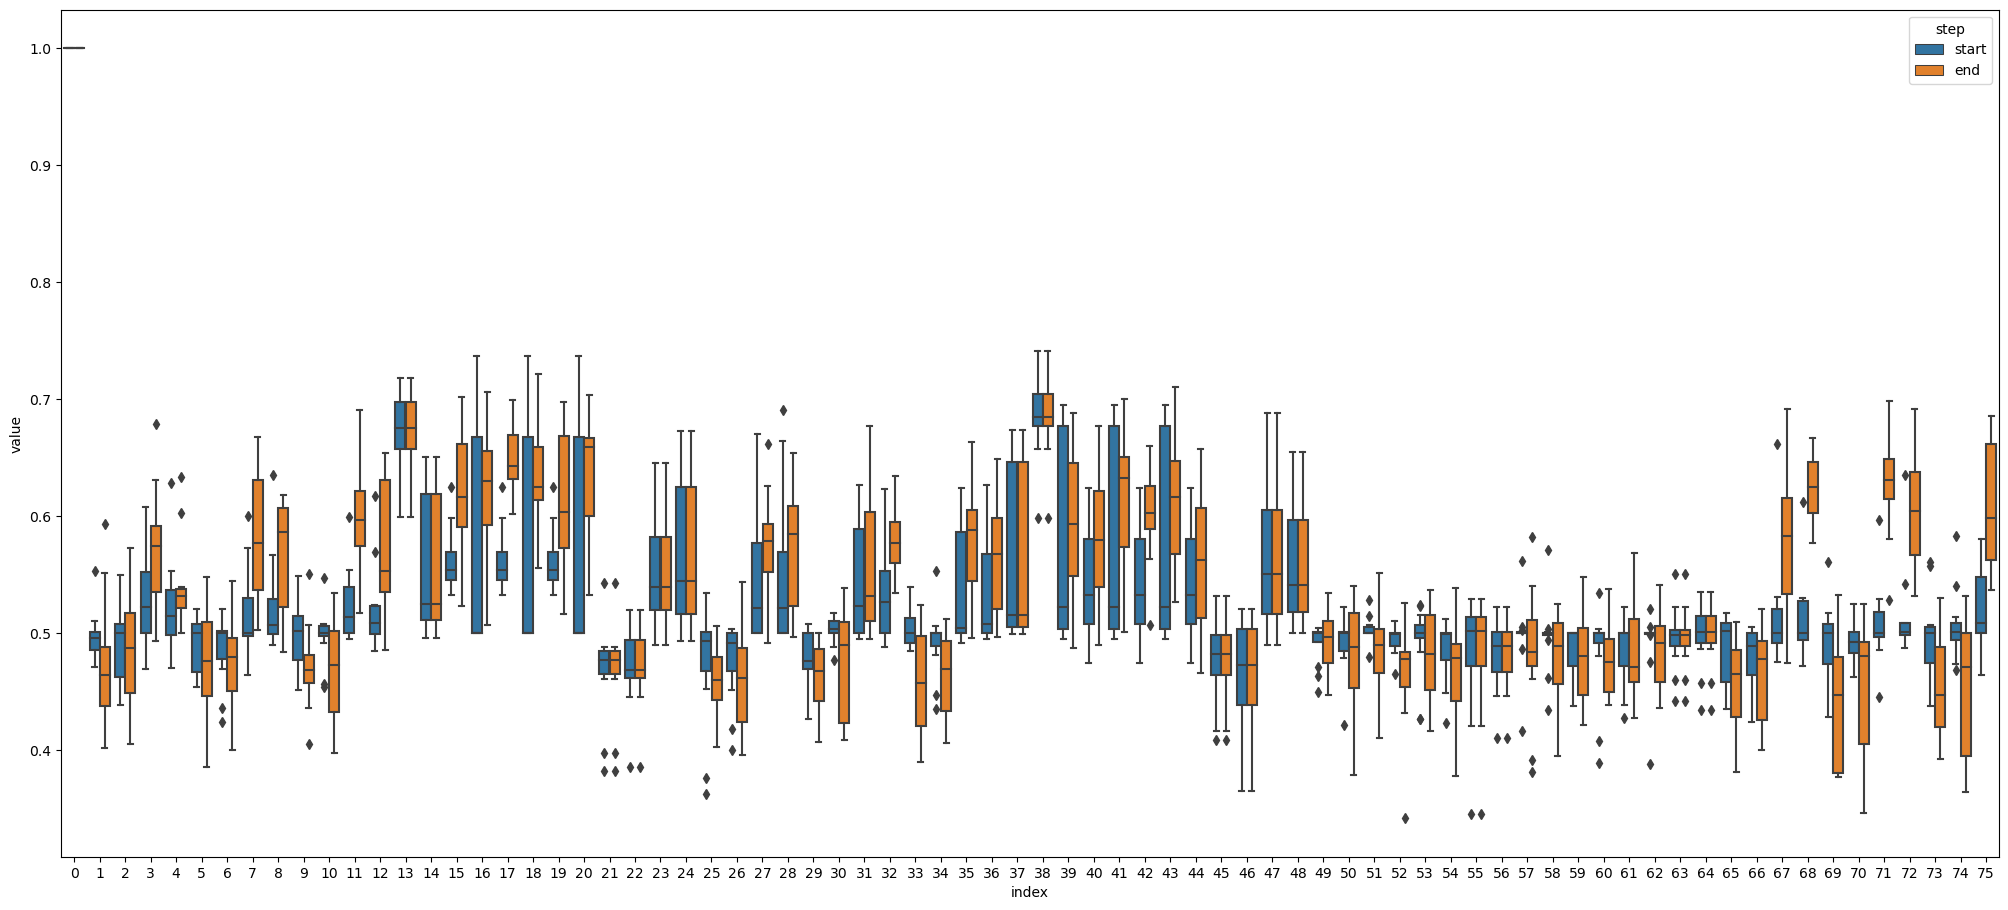

In [1028]:
plot_expert_runs_al(metrics, 4295232296, "Val", "accurancy_balanced")

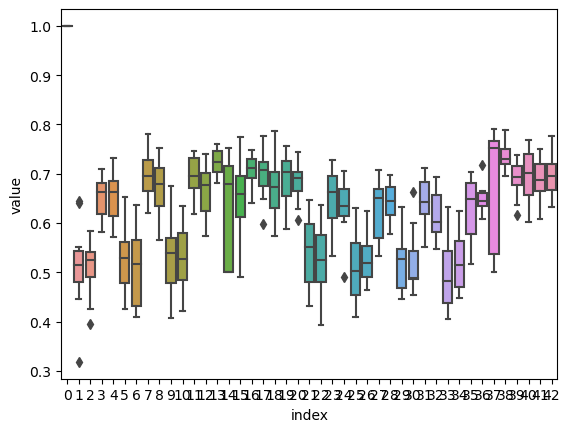

In [486]:
plot_expert_runs_end(metrics, 4323195249, "Val", "accurancy_balanced")

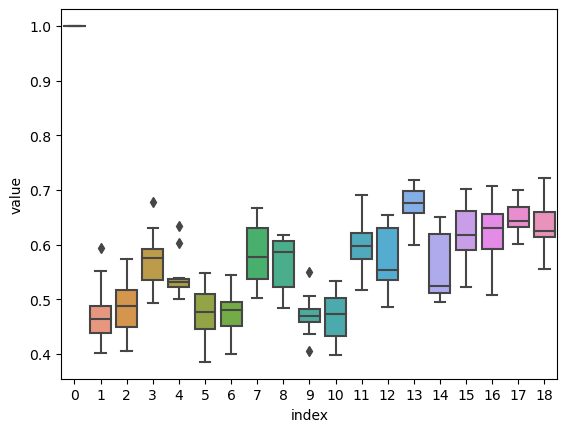

In [987]:
plot_expert_runs_end(metrics, 4295232296, "Val", "accurancy_balanced")

In [523]:
df = pd.DataFrame({"col1": []})
#df["col1"] = df["col1"].astype("category")

s = pd.Series(["MP1"])
s = s.astype("category")

df["col1"] = df["col1"].combine_first(s)